In [1]:
import pandas as pd

delays_df = pd.read_excel("../data/raw/get_around_delay_analysis.xlsx")
delays_df.head()

rental_id  car_id checkin_type     state  delay_at_checkout_in_minutes  \
0     505000  363965       mobile  canceled                           NaN   
1     507750  269550       mobile     ended                         -81.0   
2     508131  359049      connect     ended                          70.0   
3     508865  299063      connect  canceled                           NaN   
4     511440  313932       mobile     ended                           NaN   

   previous_ended_rental_id  time_delta_with_previous_rental_in_minutes  
0                       NaN                                         NaN  
1                       NaN                                         NaN  
2                       NaN                                         NaN  
3                       NaN                                         NaN  
4                       NaN                                         NaN

# Exploring the delay data

[Jump to price EDA](#exploring-the-pricing-data)

In [2]:
delays_df.describe()

rental_id         car_id  delay_at_checkout_in_minutes  \
count   21310.000000   21310.000000                  16346.000000   
mean   549712.880338  350030.603426                     59.701517   
std     13863.446964   58206.249765                   1002.561635   
min    504806.000000  159250.000000                 -22433.000000   
25%    540613.250000  317639.000000                    -36.000000   
50%    550350.000000  368717.000000                      9.000000   
75%    560468.500000  394928.000000                     67.000000   
max    576401.000000  417675.000000                  71084.000000   

       previous_ended_rental_id  time_delta_with_previous_rental_in_minutes  
count               1841.000000                                 1841.000000  
mean              550127.411733                                  279.288430  
std                13184.023111                                  254.594486  
min               505628.000000                                    0.000000  
25%               540896.000000                                   60.000000  
50%               550567.000000                                  180.000000  
75%               560823.000000                                  540.000000  
max               575053.000000                                  720.000000

Here, I thought that negative delay values were an anomaly, but it turned out to simply be early checkouts:

In [3]:
anomalous_delay_value_df = delays_df[delays_df.delay_at_checkout_in_minutes < 0]
len(anomalous_delay_value_df)

6820

In [4]:
anomalous_delay_value_df.head(30)

rental_id  car_id checkin_type  state  delay_at_checkout_in_minutes  \
1      507750  269550       mobile  ended                         -81.0   
5      511626  398802       mobile  ended                        -203.0   
6      511639  370585      connect  ended                         -15.0   
7      512303  371242       mobile  ended                         -44.0   
15     518282  364160      connect  ended                         -81.0   
16     518366  397217       mobile  ended                        -156.0   
20     519795  383720      connect  ended                        -159.0   
21     520095  404496       mobile  ended                         -16.0   
25     521352  403184       mobile  ended                         -29.0   
27     521734  190995       mobile  ended                        -251.0   
30     523800  352799       mobile  ended                        -345.0   
33     524806  337859       mobile  ended                         -26.0   
36     526798  356877       mobile  ended                         -15.0   
38     527569  314220       mobile  ended                          -2.0   
39     527627  402562      connect  ended                          -1.0   
40     528808  181625      connect  ended                         -76.0   
47     529852  363433       mobile  ended                         -68.0   
48     530646  259092       mobile  ended                        -340.0   
51     531507  355554       mobile  ended                          -4.0   
52     531526  404562       mobile  ended                        -160.0   
53     531955  317639       mobile  ended                         -30.0   
54     531961  234356       mobile  ended                         -47.0   
55     532245  361468      connect  ended                         -63.0   
56     532416  275810       mobile  ended                        -148.0   
58     532802  373061       mobile  ended                         -98.0   
59     533294  364052       mobile  ended                         -33.0   
60     533303  336902       mobile  ended                        -340.0   
61     533380  314456      connect  ended                        -167.0   
64     533670  320824      connect  ended                          -6.0   
71     534654  303652       mobile  ended                         -52.0   

    previous_ended_rental_id  time_delta_with_previous_rental_in_minutes  
1                        NaN                                         NaN  
5                        NaN                                         NaN  
6                   563782.0                                       570.0  
7                        NaN                                         NaN  
15                       NaN                                         NaN  
16                       NaN                                         NaN  
20                       NaN                                         NaN  
21                       NaN                                         NaN  
25                       NaN                                         NaN  
27                       NaN                                         NaN  
30                       NaN                                         NaN  
33                       NaN                                         NaN  
36                       NaN                                         NaN  
38                       NaN                                         NaN  
39                       NaN                                         NaN  
40                  557404.0                                       330.0  
47                       NaN                                         NaN  
48                       NaN                                         NaN  
51                       NaN                                         NaN  
52                       NaN                                         NaN  
53                       NaN                                         NaN  
54                       NaN

I decided to assume that the value in the "delay_at_checkout_in_minutes" column is how late (or early, in the case of negative values) the car is returned, with regards to the planned return time.

In [5]:
# XOR on the previous rental cols to find out 1) whether they co-occur 2) whether it reliably indicates an absence of previous rental altogether

previous_rentals_xor_df = delays_df[delays_df.time_delta_with_previous_rental_in_minutes.isna() != delays_df.previous_ended_rental_id.isna()]
len(previous_rentals_xor_df)

# The output value is 0, hinting at the fact that they are always NaN together, but converting the float columns to Int64 (with an uppercase I,
# to indicate that NaN values are left as is), made it so that I had to check if they were separately NA (which the web tells me is different from NaN)

0

This new column turned out to be a great idea:

In [6]:
delays_df_original = delays_df.copy()
delays_df["has_previous_rental"] = ~delays_df.time_delta_with_previous_rental_in_minutes.isna()
delays_df.head()

rental_id  car_id checkin_type     state  delay_at_checkout_in_minutes  \
0     505000  363965       mobile  canceled                           NaN   
1     507750  269550       mobile     ended                         -81.0   
2     508131  359049      connect     ended                          70.0   
3     508865  299063      connect  canceled                           NaN   
4     511440  313932       mobile     ended                           NaN   

   previous_ended_rental_id  time_delta_with_previous_rental_in_minutes  \
0                       NaN                                         NaN   
1                       NaN                                         NaN   
2                       NaN                                         NaN   
3                       NaN                                         NaN   
4                       NaN                                         NaN   

   has_previous_rental  
0                False  
1                False  
2                False  
3                False  
4                False

In [7]:
delays_df.state.value_counts()

state
ended       18045
canceled     3265
Name: count, dtype: int64

In [8]:
delays_df.isna().sum()

rental_id                                         0
car_id                                            0
checkin_type                                      0
state                                             0
delay_at_checkout_in_minutes                   4964
previous_ended_rental_id                      19469
time_delta_with_previous_rental_in_minutes    19469
has_previous_rental                               0
dtype: int64

I found out that a small number of cancelled bookings had a NaN in delay_at_checkout_in_minutes, but not in previous_ended_rental_id. This hints at the fact that some NaNs could mean "checked out right on time".

In [9]:
((delays_df.state == "canceled") & delays_df.delay_at_checkout_in_minutes.isna() & delays_df.previous_ended_rental_id.isna() & delays_df.time_delta_with_previous_rental_in_minutes.isna()).value_counts()

False    18275
True      3035
Name: count, dtype: int64

In [10]:
((delays_df.state == "canceled") & delays_df.delay_at_checkout_in_minutes.isna()).value_counts()

False    18046
True      3264
Name: count, dtype: int64

In [11]:
((delays_df.state == "canceled") & delays_df.delay_at_checkout_in_minutes.isna() & ~delays_df.previous_ended_rental_id.isna()).value_counts()

False    21081
True       229
Name: count, dtype: int64

In [12]:
cancelled_rides_with_previous_rental_df = delays_df[["rental_id", "state", "previous_ended_rental_id"]]
cancelled_rides_with_previous_rental_df["is_cancelled_and_has_previous_rental"] = ((delays_df.state == "canceled") & delays_df.delay_at_checkout_in_minutes.isna() & ~delays_df.previous_ended_rental_id.isna())
cancelled_rides_with_previous_rental_df[cancelled_rides_with_previous_rental_df["is_cancelled_and_has_previous_rental"] == True]

/var/folders/6m/4bfx39_j0519_3g3r0sp6fbw0000gn/T/ipykernel_14854/3445216797.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cancelled_rides_with_previous_rental_df["is_cancelled_and_has_previous_rental"] = ((delays_df.state == "canceled") & delays_df.delay_at_checkout_in_minutes.isna() & ~delays_df.previous_ended_rental_id.isna())


rental_id     state  previous_ended_rental_id  \
204       543768  canceled                  543010.0   
242       546160  canceled                  546578.0   
504       564627  canceled                  552005.0   
637       568657  canceled                  566412.0   
669       516550  canceled                  545076.0   
...          ...       ...                       ...   
21172     566228  canceled                  568465.0   
21197     567305  canceled                  552222.0   
21230     569706  canceled                  558088.0   
21269     568049  canceled                  562174.0   
21272     568241  canceled                  566136.0   

       is_cancelled_and_has_previous_rental  
204                                    True  
242                                    True  
504                                    True  
637                                    True  
669                                    True  
...                                     ...  
21172                                  True  
21197                                  True  
21230                                  True  
21269                                  True  
21272                                  True  

[229 rows x 4 columns]

In [13]:
# Checking if some of the bookings in the data used paper, as was mentioned in the project description.
delays_df.checkin_type.value_counts()

checkin_type
mobile     17003
connect     4307
Name: count, dtype: int64

Since we're looking for info on late returns, we can remove instances where the vehicle was returned early:

In [14]:
late_returns_df = delays_df[~delays_df.delay_at_checkout_in_minutes.isna() & (delays_df.delay_at_checkout_in_minutes >= 0)]
late_returns_df.head()

rental_id  car_id checkin_type  state  delay_at_checkout_in_minutes  \
2      508131  359049      connect  ended                          70.0   
9      513434  256528      connect  ended                          23.0   
12     514257  402596       mobile  ended                         214.0   
13     515147  257466       mobile  ended                          15.0   
17     518895  398816       mobile  ended                          66.0   

    previous_ended_rental_id  time_delta_with_previous_rental_in_minutes  \
2                        NaN                                         NaN   
9                        NaN                                         NaN   
12                       NaN                                         NaN   
13                       NaN                                         NaN   
17                       NaN                                         NaN   

    has_previous_rental  
2                 False  
9                 False  
12                False  
13                False  
17                False

Checking to what extent cancellations are due to delays.

In [15]:
has_previous_rental_df = delays_df[delays_df.has_previous_rental == True]
has_previous_rental_df.head()

rental_id  car_id checkin_type  state  delay_at_checkout_in_minutes  \
6      511639  370585      connect  ended                         -15.0   
19     519491  312389       mobile  ended                          58.0   
23     521156  392479       mobile  ended                           NaN   
34     525044  349751       mobile  ended                           NaN   
40     528808  181625      connect  ended                         -76.0   

    previous_ended_rental_id  time_delta_with_previous_rental_in_minutes  \
6                   563782.0                                       570.0   
19                  545639.0                                       420.0   
23                  537298.0                                         0.0   
34                  510607.0                                        60.0   
40                  557404.0                                       330.0   

    has_previous_rental  
6                  True  
19                 True  
23                 True  
34                 True  
40                 True

In [16]:
has_previous_rental_df.state.value_counts()

state
ended       1612
canceled     229
Name: count, dtype: int64

In [17]:
has_previous_rental_df[has_previous_rental_df.state == "canceled"]

rental_id  car_id checkin_type     state  delay_at_checkout_in_minutes  \
204       543768  374169      connect  canceled                           NaN   
242       546160  352528      connect  canceled                           NaN   
504       564627  341431       mobile  canceled                           NaN   
637       568657  317378      connect  canceled                           NaN   
669       516550  377700       mobile  canceled                           NaN   
...          ...     ...          ...       ...                           ...   
21172     566228  390871      connect  canceled                           NaN   
21197     567305  405564       mobile  canceled                           NaN   
21230     569706  245154      connect  canceled                           NaN   
21269     568049  381499      connect  canceled                           NaN   
21272     568241  396409       mobile  canceled                           NaN   

       previous_ended_rental_id  time_delta_with_previous_rental_in_minutes  \
204                    543010.0                                       210.0   
242                    546578.0                                       630.0   
504                    552005.0                                       150.0   
637                    566412.0                                       210.0   
669                    545076.0                                       720.0   
...                         ...                                         ...   
21172                  568465.0                                        60.0   
21197                  552222.0                                         0.0   
21230                  558088.0                                       660.0   
21269                  562174.0                                       720.0   
21272                  566136.0                                       570.0   

       has_previous_rental  
204                   True  
242                   True  
504                   True  
637                   True  
669                   True  
...                    ...  
21172                 True  
21197                 True  
21230                 True  
21269                 True  
21272                 True  

[229 rows x 8 columns]

Here I was trying to see what the correlation between time_delta_with_previous_rental_in_minutes and num_cancelled_rides_at_that_time_delta looked like. \
The result seemed weird to me, since you would think that the more time elapses between each booking, the fewer people will cancel due to late returns. \
I could not figure out what this was due to and decided to move on.

In [18]:
cancellations_and_deltas_dict = {"time_delta_with_previous_rental_in_minutes": [], "num_cancelled_rides_at_that_time_delta": []}

cancelled_has_previous_rental_deltas = (has_previous_rental_df[has_previous_rental_df.state == "canceled"])["time_delta_with_previous_rental_in_minutes"]

for d in range(int(max(has_previous_rental_df.time_delta_with_previous_rental_in_minutes.to_list()))): # d is for delay
    cancellations_and_deltas_dict["time_delta_with_previous_rental_in_minutes"].append(d)
    num_cancellations = len(cancelled_has_previous_rental_deltas[cancelled_has_previous_rental_deltas <= d])
    cancellations_and_deltas_dict["num_cancelled_rides_at_that_time_delta"].append(num_cancellations)


In [19]:
cancellations_and_deltas_df = pd.DataFrame(cancellations_and_deltas_dict)
cancellations_and_deltas_df.head()

time_delta_with_previous_rental_in_minutes  \
0                                           0   
1                                           1   
2                                           2   
3                                           3   
4                                           4   

   num_cancelled_rides_at_that_time_delta  
0                                      35  
1                                      35  
2                                      35  
3                                      35  
4                                      35

In [20]:
import plotly.express as px

fig = px.line(
    data_frame=cancellations_and_deltas_df,
    x="time_delta_with_previous_rental_in_minutes",
    y="num_cancelled_rides_at_that_time_delta",
)
fig.show()

I will call the delay to add after the end of a booking a "buffer", in order to differenciate it from the delay caused by late returns.

Create four cols:
1. One with a buffer time value in minutes comprised between 0 and the maximum late return value,
2. One with the percentage of late return instances this buffer would help with.
3. One with a dummy income per minute to allow us to count how much money is lost per extra minute of buffer: the income lost at the maximum delay in the dataset is 100.
4. One with the percentage of rides (only among those that have a previous rental) that would not have been hindered by the buffer time (time delta something something).

Create a line plot that combines the three DFs as three lines. The intersection zone contains the optimal buffer time (but the product owner may decide to tweak that value somewhat).

In [21]:
max_late_return_value = int(max(late_returns_df.delay_at_checkout_in_minutes.to_list()))
max_late_return_value

71084

In [22]:
values_to_optimise_dict = {"buffer_value": [], "percentage_helped_late_returns": [], "dummy_income_loss": [], "percentage_hindered_bookings": []}

late_returns_df_len = len(late_returns_df)
has_previous_rental_df_len = len(has_previous_rental_df)

for b in range(max_late_return_value):

    values_to_optimise_dict["buffer_value"].append(b)
    
    num_helped_late_returns = len(late_returns_df[late_returns_df.delay_at_checkout_in_minutes <= b])
    values_to_optimise_dict["percentage_helped_late_returns"].append((num_helped_late_returns / late_returns_df_len) * 100)

    dummy_income_loss = (b / max_late_return_value) * 100
    values_to_optimise_dict["dummy_income_loss"].append(dummy_income_loss)

    num_hindered_bookings = len(has_previous_rental_df[has_previous_rental_df.time_delta_with_previous_rental_in_minutes > b])
    values_to_optimise_dict["percentage_hindered_bookings"].append((num_hindered_bookings / has_previous_rental_df_len) * 100)

In [23]:
values_to_optimise_df = pd.DataFrame(values_to_optimise_dict)
values_to_optimise_df.head()

buffer_value  percentage_helped_late_returns  dummy_income_loss  \
0             0                        1.280705           0.000000   
1             1                        2.435440           0.001407   
2             2                        4.020575           0.002814   
3             3                        5.469242           0.004220   
4             4                        7.201344           0.005627   

   percentage_hindered_bookings  
0                     84.845193  
1                     84.845193  
2                     84.845193  
3                     84.845193  
4                     84.845193

In [24]:
import plotly.graph_objects as go

fig = go.Figure()

buffer_value = values_to_optimise_df["buffer_value"].to_list()
percentage_helped_late_returns = values_to_optimise_df["percentage_helped_late_returns"].to_list()
dummy_income_loss = values_to_optimise_df["dummy_income_loss"].to_list()
percentage_hindered_bookings = values_to_optimise_df["percentage_hindered_bookings"].to_list()


fig.add_trace(go.Scatter(
    x=buffer_value, y=percentage_helped_late_returns,
    mode='lines',
    name='percentage_helped_late_returns',
    line={"color": 'blue', "width": 2}
))

fig.add_trace(go.Scatter(
    x=buffer_value, y=dummy_income_loss,
    mode='lines',
    name='dummy_income_loss',
    line={"color": 'red', "width": 2}
))

fig.add_trace(go.Scatter(
    x=buffer_value, y=percentage_hindered_bookings,
    mode='lines',
    name='percentage_hindered_bookings',
    line={"color": 'green', "width": 2}
))

fig.update_layout(
    title="Finding the optimal buffer time before a new booking",
    xaxis_title="Buffer in minutes",
    yaxis_title="",
    legend={"title": "Labels"},
    template="plotly_white"
)

# Show the plot
fig.show()


The max late return value is waaay too far from the other values to make the plot usable. Trying again with a max value of 1,000.

In [25]:
values_to_optimise_dict_1000 = {"buffer_value": [], "percentage_helped_late_returns": [], "dummy_income_loss": [], "percentage_hindered_bookings": []}

late_returns_df_len = len(late_returns_df)
has_previous_rental_df_len = len(has_previous_rental_df)

for b in range(1_000):

    values_to_optimise_dict_1000["buffer_value"].append(b)
    
    num_helped_late_returns = len(late_returns_df[late_returns_df.delay_at_checkout_in_minutes <= b])
    values_to_optimise_dict_1000["percentage_helped_late_returns"].append((num_helped_late_returns / late_returns_df_len) * 100)

    dummy_income_loss = (b / 1_000) * 100 # This could be made simpler, but you see what I am doing better
    values_to_optimise_dict_1000["dummy_income_loss"].append(dummy_income_loss)

    num_hindered_bookings = len(has_previous_rental_df[has_previous_rental_df.time_delta_with_previous_rental_in_minutes > b])
    values_to_optimise_dict_1000["percentage_hindered_bookings"].append((num_hindered_bookings / has_previous_rental_df_len) * 100)


values_to_optimise_df_1000 = pd.DataFrame(values_to_optimise_dict_1000)


import plotly.graph_objects as go

fig = go.Figure()

buffer_value = values_to_optimise_df_1000["buffer_value"].to_list()
percentage_helped_late_returns = values_to_optimise_df_1000["percentage_helped_late_returns"].to_list()
dummy_income_loss = values_to_optimise_df_1000["dummy_income_loss"].to_list()
percentage_hindered_bookings = values_to_optimise_df_1000["percentage_hindered_bookings"].to_list()


fig.add_trace(go.Scatter(
    x=buffer_value, y=percentage_helped_late_returns,
    mode='lines',
    name='percentage_helped_late_returns',
    line={"color": 'blue', "width": 2}
))

fig.add_trace(go.Scatter(
    x=buffer_value, y=dummy_income_loss,
    mode='lines',
    name='dummy_income_loss',
    line={"color": 'red', "width": 2}
))

fig.add_trace(go.Scatter(
    x=buffer_value, y=percentage_hindered_bookings,
    mode='lines',
    name='percentage_hindered_bookings',
    line={"color": 'green', "width": 2}
))

fig.update_layout(
    title="Finding the optimal buffer time before a new booking",
    xaxis_title="Buffer in minutes",
    yaxis_title="",
    legend={"title": "Labels"},
    template="plotly_white"
)

# Show the plot
fig.show()


The graph shows that the optimal buffer time is about an hour and a half, for the percentage of bookings that would have been kept from happening should a given buffer have been put in place, versus the percentage of late returns that a given buffer would have made unproblematic to the following user. All the while keeping the revenue loss negligible.

I would like to remove the outliers beyond $3\sigma$ from the mean and display the plot again for all the non-outlying values, to see if I can make the dummy income loss value more useful.

/opt/anaconda3/envs/jedha-dsfs-ft-35/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning:

scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 16346.



Shapiro-Wilk test statistic = 0.1255, p-value = 0.0000
Reject H0: Data does NOT look normally distributed

Anderson-Darling statistic: 4074.3599906051313
Significance 15.0%: critical value 0.576
Significance 10.0%: critical value 0.656
Significance 5.0%: critical value 0.787
Significance 2.5%: critical value 0.918
Significance 1.0%: critical value 1.092


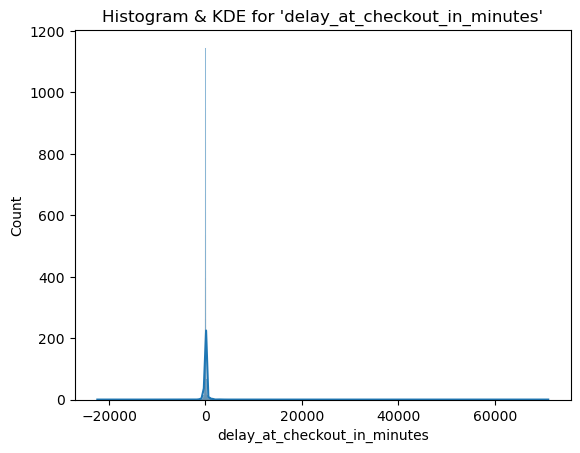

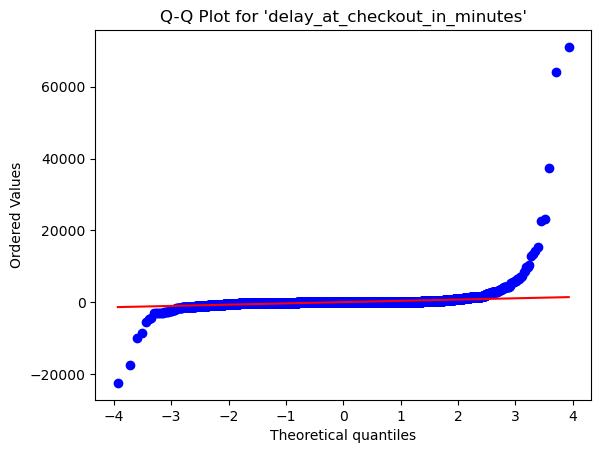

In [26]:
# Checking to what extent 3sigma is relevant by looking at how normal the distribution of delay_at_checkout_in_minutes is

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

no_delays_df = delays_df[~delays_df.delay_at_checkout_in_minutes.isna()]

col = "delay_at_checkout_in_minutes"

# Shapiro-Wilk test (good for small to medium samples)
stat, p_value = stats.shapiro(no_delays_df[col])
print(f"Shapiro-Wilk test statistic = {stat:.4f}, p-value = {p_value:.4f}")
if p_value > 0.05:
    print("Fail to reject H0: Data looks normally distributed")
else:
    print("Reject H0: Data does NOT look normally distributed")

# Anderson-Darling test (returns critical values)
anderson_result = stats.anderson(no_delays_df[col])
print("\nAnderson-Darling statistic:", anderson_result.statistic)
for i, (cv, sig) in enumerate(zip(anderson_result.critical_values, anderson_result.significance_level)):
    print(f"Significance {sig}%: critical value {cv}")

# Plot histogram with KDE
sns.histplot(no_delays_df[col], kde=True)
plt.title(f"Histogram & KDE for '{col}'")
plt.show()

# Q-Q plot
stats.probplot(no_delays_df[col], dist="norm", plot=plt)
plt.title(f"Q-Q Plot for '{col}'")
plt.show()


The two plots show that there is a small number of extreme outliers, and that the majority of the values are contained within a much smaller range. $3\sigma$ might not work, because the mean distance from the mean is going to be skewed by the extreme outliers. Let's look at the std:

In [27]:
std = late_returns_df["delay_at_checkout_in_minutes"].std()
print(std)

1235.863903538343


In [28]:
std/60

20.59773172563905

This represents twenty hours, which is plenty. Let's stick to that.

In [29]:
import numpy as np

col = "delay_at_checkout_in_minutes"

mean = late_returns_df[col].mean()
std = late_returns_df[col].std()

late_returns_df_fewer_outliers = late_returns_df[(np.abs(late_returns_df[col] - mean) <= std)]

In [30]:
has_previous_rental_df_fewer_outliers = has_previous_rental_df[(np.abs(has_previous_rental_df[col] - mean) <= std)]

In [31]:
values_to_optimise_dict_fewer_outliers = {"buffer_value": [], "percentage_helped_late_returns": [], "dummy_income_loss": [], "percentage_hindered_bookings": []}

late_returns_df_len = len(late_returns_df_fewer_outliers)
has_previous_rental_df_len = len(has_previous_rental_df_fewer_outliers)

max_late_return_value_fewer_outliers = int(max(late_returns_df_fewer_outliers.delay_at_checkout_in_minutes.to_list()))

for b in range(max_late_return_value_fewer_outliers):

    values_to_optimise_dict_fewer_outliers["buffer_value"].append(b)
    
    num_helped_late_returns = len(late_returns_df_fewer_outliers[late_returns_df_fewer_outliers.delay_at_checkout_in_minutes <= b])
    values_to_optimise_dict_fewer_outliers["percentage_helped_late_returns"].append((num_helped_late_returns / late_returns_df_len) * 100)

    dummy_income_loss = (b / max_late_return_value_fewer_outliers) * 100
    values_to_optimise_dict_fewer_outliers["dummy_income_loss"].append(dummy_income_loss)

    num_hindered_bookings = len(has_previous_rental_df_fewer_outliers[has_previous_rental_df_fewer_outliers.time_delta_with_previous_rental_in_minutes > b])
    values_to_optimise_dict_fewer_outliers["percentage_hindered_bookings"].append((num_hindered_bookings / has_previous_rental_df_len) * 100)


values_to_optimise_df_fewer_outliers = pd.DataFrame(values_to_optimise_dict_fewer_outliers)


import plotly.graph_objects as go

fig = go.Figure()

buffer_value = values_to_optimise_df_fewer_outliers["buffer_value"].to_list()
percentage_helped_late_returns = values_to_optimise_df_fewer_outliers["percentage_helped_late_returns"].to_list()
dummy_income_loss = values_to_optimise_df_fewer_outliers["dummy_income_loss"].to_list()
percentage_hindered_bookings = values_to_optimise_df_fewer_outliers["percentage_hindered_bookings"].to_list()


fig.add_trace(go.Scatter(
    x=buffer_value, y=percentage_helped_late_returns,
    mode='lines',
    name='percentage_helped_late_returns',
    line={"color": 'blue', "width": 2}
))

fig.add_trace(go.Scatter(
    x=buffer_value, y=dummy_income_loss,
    mode='lines',
    name='dummy_income_loss',
    line={"color": 'red', "width": 2}
))

fig.add_trace(go.Scatter(
    x=buffer_value, y=percentage_hindered_bookings,
    mode='lines',
    name='percentage_hindered_bookings',
    line={"color": 'green', "width": 2},
    line_shape="spline"
))

fig.update_layout(
    title="Finding the optimal buffer time before a new booking",
    xaxis_title="Buffer in minutes",
    yaxis_title="",
    legend={"title": "Labels"},
    template="plotly_white"
)

# Show the plot
fig.show()


Without the outliers, the ideal buffer time is still about 90 minutes, for an amount of lost revenue below 10% of the amount lost if we were to wait the highest time under $1\sigma$ of the sampled late returns.

In [32]:
values_to_optimise_df_fewer_outliers.describe()

buffer_value  percentage_helped_late_returns  dummy_income_loss  \
count   1434.000000                     1434.000000        1434.000000   
mean     716.500000                       91.694357          49.965132   
std      414.104455                       14.680362          28.877577   
min        0.000000                        1.306630           0.000000   
25%      358.250000                       92.519010          24.982566   
50%      716.500000                       96.712006          49.965132   
75%     1074.750000                       98.896862          74.947699   
max     1433.000000                       99.989290          99.930265   

       percentage_hindered_bookings  
count                   1434.000000  
mean                      19.284950  
std                       23.882690  
min                        0.000000  
25%                        0.000000  
50%                        7.496653  
75%                       35.542169  
max                       85.073628

# Exploring the pricing data

[Jump to delays EDA](#exploring-the-delay-data)

In [33]:
import pandas as pd

pricing_df = pd.read_csv("Data/get_around_pricing_project.csv", index_col=0)
pricing_df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'Data/get_around_pricing_project.csv'

I have to do a linear regression:
- There doesn't seem to be any columns that are irrelevant or with too many modalities
- A lot of categorical columns: one-hot encoding (drop one of the cols every time)
- A lot of columns: lasso or ridge (regularisation)

In [ ]:
pricing_df.describe(include="all")

model_key       mileage  engine_power    fuel paint_color car_type  \
count       4843  4.843000e+03    4843.00000    4843        4843     4843   
unique        28           NaN           NaN       4          10        8   
top      Citroën           NaN           NaN  diesel       black   estate   
freq         969           NaN           NaN    4641        1633     1606   
mean         NaN  1.409628e+05     128.98823     NaN         NaN      NaN   
std          NaN  6.019674e+04      38.99336     NaN         NaN      NaN   
min          NaN -6.400000e+01       0.00000     NaN         NaN      NaN   
25%          NaN  1.029135e+05     100.00000     NaN         NaN      NaN   
50%          NaN  1.410800e+05     120.00000     NaN         NaN      NaN   
75%          NaN  1.751955e+05     135.00000     NaN         NaN      NaN   
max          NaN  1.000376e+06     423.00000     NaN         NaN      NaN   

       private_parking_available has_gps has_air_conditioning automatic_car  \
count                       4843    4843                 4843          4843   
unique                         2       2                    2             2   
top                         True    True                False         False   
freq                        2662    3839                 3865          3881   
mean                         NaN     NaN                  NaN           NaN   
std                          NaN     NaN                  NaN           NaN   
min                          NaN     NaN                  NaN           NaN   
25%                          NaN     NaN                  NaN           NaN   
50%                          NaN     NaN                  NaN           NaN   
75%                          NaN     NaN                  NaN           NaN   
max                          NaN     NaN                  NaN           NaN   

       has_getaround_connect has_speed_regulator winter_tires  \
count                   4843                4843         4843   
unique                     2                   2            2   
top                    False               False         True   
freq                    2613                3674         4514   
mean                     NaN                 NaN          NaN   
std                      NaN                 NaN          NaN   
min                      NaN                 NaN          NaN   
25%                      NaN                 NaN          NaN   
50%                      NaN                 NaN          NaN   
75%                      NaN                 NaN          NaN   
max                      NaN                 NaN          NaN   

        rental_price_per_day  
count            4843.000000  
unique                   NaN  
top                      NaN  
freq                     NaN  
mean              121.214536  
std                33.568268  
min                10.000000  
25%               104.000000  
50%               119.000000  
75%               136.000000  
max               422.000000

In [ ]:
pricing_df.isna().sum()

model_key                    0
mileage                      0
engine_power                 0
fuel                         0
paint_color                  0
car_type                     0
private_parking_available    0
has_gps                      0
has_air_conditioning         0
automatic_car                0
has_getaround_connect        0
has_speed_regulator          0
winter_tires                 0
rental_price_per_day         0
dtype: int64

In [ ]:
for col in ['model_key', 'fuel', 'paint_color',
       'car_type', 'private_parking_available', 'has_gps',
       'has_air_conditioning', 'automatic_car', 'has_getaround_connect',
       'has_speed_regulator', 'winter_tires']:
    print(pricing_df[col].value_counts())

model_key
Citroën        969
Renault        916
BMW            827
Peugeot        642
Audi           526
Nissan         275
Mitsubishi     231
Mercedes        97
Volkswagen      65
Toyota          53
SEAT            46
Subaru          44
PGO             33
Ferrari         33
Opel            33
Maserati        18
Suzuki           8
Porsche          6
Ford             5
KIA Motors       3
Alfa Romeo       3
Fiat             2
Lexus            2
Lamborghini      2
Mazda            1
Honda            1
Mini             1
Yamaha           1
Name: count, dtype: int64
fuel
diesel           4641
petrol            191
hybrid_petrol       8
electro             3
Name: count, dtype: int64
paint_color
black     1633
grey      1175
blue       710
white      538
brown      341
silver     329
red         52
beige       41
green       18
orange       6
Name: count, dtype: int64
car_type
estate         1606
sedan          1168
suv            1058
hatchback       699
subcompact      117
coupe           

In [ ]:
pricing_df.dtypes

model_key                    object
mileage                       int64
engine_power                  int64
fuel                         object
paint_color                  object
car_type                     object
private_parking_available      bool
has_gps                        bool
has_air_conditioning           bool
automatic_car                  bool
has_getaround_connect          bool
has_speed_regulator            bool
winter_tires                   bool
rental_price_per_day          int64
dtype: object